# 고객 세분화 분류 분석

- RFM 거래날짜, 거래빈도, 평균금액으로 고객 분류
    - 충성, 잠재충성, (잠재이탈)휴면, 신규
    
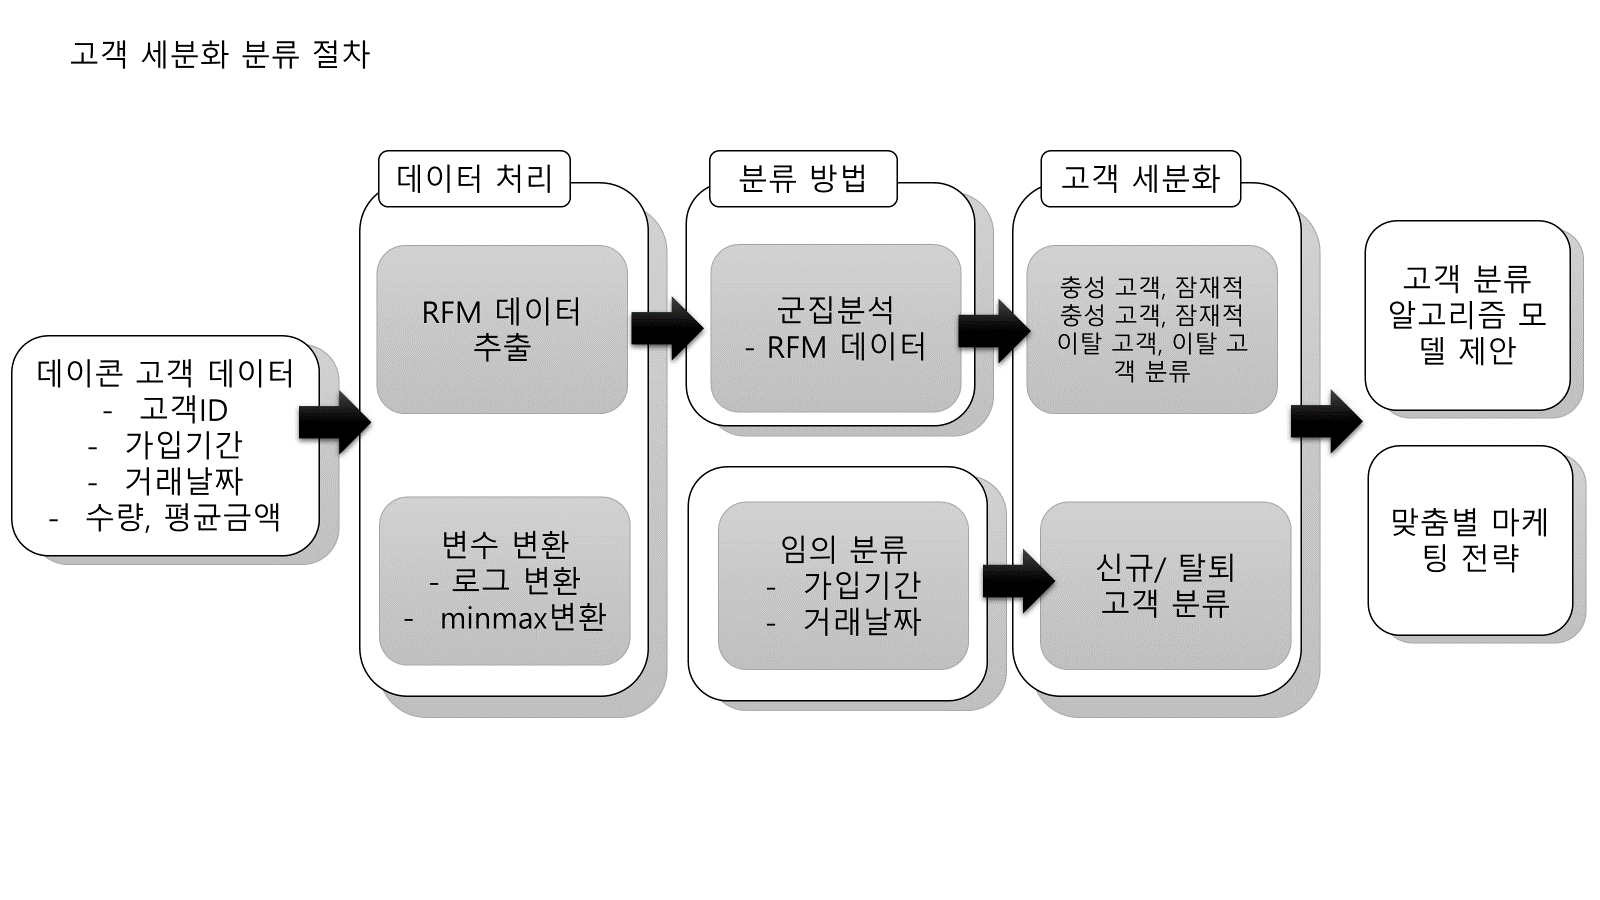

---

### import & read data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# 한글깨짐해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
df_customer= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Customer_info.csv")
df_sales= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Onlinesales_info.csv")
df_discount= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Discount_info.csv")

df = pd.merge(df_customer, df_sales,how='right',on = '고객ID')
df['거래금액']= df['수량'] * df['평균금액'] # 거래금액 추정

---

### 변수 설정

- 최근날짜
- 거래빈도
- 거래금액

#### 최근날짜 

- 가장 마지막 날짜(2019-12-31)를 기준으로 각 유저의 가장 최근 거래 날짜를 이용
- $$ recency = distance(현재날짜- 최근거래날짜_{ID}+1)) \times -1 $$


#### 거래빈도

- 각 유저의 거래ID를 추적, 빈도를 구함
- $$ frequency = count(고객의 거래ID) $$

####  거래금액

- 각 유저의 평균금액과 수량을 이용하여 거래금액을 추적
- $$ monetary= \sum^n_{i=1}( 평균금액_i \times 수량_i) $$ 

#### 변수변환

- 원활한 모델 적합을 위해 변수들을 변환
- 로그변환 후 정규화 진행

---

### 고객 추출


In [3]:
class customer_tool:
    ####################################################################
    # 고객 추출 클래스
    # 고객의 ID를 기준으로 그룹으로 묶고 인덱스 반환
    # 고객의 ID에 해당하는 데이터프레임을 생성
    def __init__(self,df):
        self.df = df
        customer_lst= self.df.groupby('고객ID').count().index.values
        self.customer_lst = customer_lst
    def customer(self,idnum):
        self.dfID = df[df['고객ID'] == self.customer_lst[idnum]]
        return self.dfID

In [4]:
tool = customer_tool(df)
tool.customer(1).head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액
10667,USER_0001,남,New York,20,Transaction_5262,2019-03-24,Product_0945,Office,1,2.99,14.41,Clicked,2.99
10668,USER_0001,남,New York,20,Transaction_5262,2019-03-24,Product_0965,Office,1,9.99,14.41,Used,9.99
10669,USER_0001,남,New York,20,Transaction_5263,2019-03-24,Product_0981,Nest-USA,1,149.00,6.50,Used,149.00
10670,USER_0001,남,New York,20,Transaction_5263,2019-03-24,Product_0985,Nest-USA,5,79.00,6.50,Clicked,395.00
10671,USER_0001,남,New York,20,Transaction_5264,2019-03-24,Product_0844,Bags,4,4.99,49.73,Not Used,19.96


### RFM example

`-` 고객 1358의 거래날짜, 거래횟수, 총 거래금액

In [5]:
#print('마지막 거래날짜', tool.customer(1358)['가입기간'][0])
print('최근 거래날짜',tool.customer(1358)['거래날짜'][:1].values)
print('마지막 거래날짜',tool.customer(1358)['거래날짜'][-1:].values)
print('거래횟수',tool.customer(1358).groupby('거래ID').count().shape[0])
print('총 거래 금액',tool.customer(1358)['평균금액'].sum())

최근 거래날짜 ['2019-01-01']
마지막 거래날짜 ['2019-01-26']
거래횟수 177
총 거래 금액 20483.980000000003


`-` 고객 0의 거래날짜, 거래횟수, 총 거래금액

In [6]:
print('최근 거래날짜',tool.customer(0)['거래날짜'][:1].values)
print('마지막 거래날짜',tool.customer(0)['거래날짜'][-1:].values)
print('거래횟수',tool.customer(0).groupby('거래ID').count().shape[0])
print('총 거래 금액',tool.customer(0)['평균금액'].sum())

최근 거래날짜 ['2019-09-15']
마지막 거래날짜 ['2019-09-15']
거래횟수 1
총 거래 금액 25.49


---

### 기존 고객의 거래날짜, 빈도, 금액, 가입기간 추출

- 고객 추출 클래스를 이용하여 기존의 고객의 최근 거래날, 빈도, 금액등을 추출하고 데이터프레임 생성

In [7]:
def f(df):
    a= df['거래날짜'][:1].values.tolist()
    a1=datetime.strptime(a[0], '%Y-%m-%d').strftime('%Y-%m-%d')
    
    b=df['거래날짜'][-1:].values.tolist()
    b2=datetime.strptime(b[0], '%Y-%m-%d').strftime('%Y-%m-%d')
    b3 =df['가입기간'][:1].values
    
    c=df.groupby('거래ID').count().shape[0]
    d=df['거래금액'].sum()
    return a1,b2,float(b3),c,d

In [8]:
RFM_df = pd.DataFrame([f(tool.customer(i)) for i in range(tool.customer_lst.shape[0])])
RFM_df.columns = ['최초거래날짜', '최근거래날짜', '가입기간','거래빈도','거래총금액']
RFM_df['최근거래날짜'] = pd.to_datetime(RFM_df['최근거래날짜'])
RFM_df['최초거래날짜'] = pd.to_datetime(RFM_df['최초거래날짜'])

In [9]:
RFM_df.head()

,최초거래날짜,최근거래날짜,가입기간,거래빈도,거래총금액
0,2019-09-15,2019-09-15,31.0,1,30.99
1,2019-03-24,2019-11-02,20.0,31,13834.90
2,2019-06-22,2019-10-19,39.0,8,1442.12
3,2019-12-14,2019-12-14,25.0,11,1360.07
4,2019-09-15,2019-09-15,31.0,13,1442.47


---

### 고객 세분화 등급
`-` RFM을 기준으로 총 4개로 세분화
    
    
- 충성고객
    - 최근 거래, 거래 빈도, 거래 금액이 높은 고객
- 잠재적 충성고객
    - 충성 고객에 비해 상대적으로 낮지만 활동이 준수한 고객
- 잠재적 이탈고객
    - 최근 거래, 거래빈도, 거래 금액의 변화가 둔해지는 고객
- 이탈고객
    - 최근 거래, 거래빈도, 거래 금액이 확실히 낮게 유지되는 고객
    
`-` 가입기간, 거래날짜로 2개의 고객 등급을 추가 고려
- 신규고객 및 복귀고객(명칭은 정확하지 않음)
    - 가입기간이 3개월이내, 최초거래날짜가 3개월 이내인 고객
- 탈퇴고객
    - 최근 거래 날짜의 월을 기준으로 가입기간을 더하였을 때 2019/12월까지 나오지 않는 고객
    - 예시 : 최근 거래날짜가 2019/3월, 가입기간이 2개월일 때 이는 5월달에 탈퇴를 한것으로 추정
        

### 군집분석 변수 변환

- 모델에 적합하기 위한 변수변환
- 일정 가입기간 이하는 신규고객으로 배정
- 모델 피팅에서 신규고객의 데이터 활용 x

### `-` 탈퇴고객 추출

In [10]:
semiout= RFM_df[RFM_df['가입기간'] <13]
semioutindex= semiout['최근거래날짜'].index
semioutindex[0]

13

In [11]:
semioutterm= np.array([semiout['가입기간'][semioutindex[i]] for i in range(len(semioutindex))])
semioutmonth= np.array([semiout['최근거래날짜'][semioutindex[i]].month for i in range(len(semioutindex))])
out_customer= semiout[semioutmonth + semioutterm < 12] # 탈퇴고객
out_customer.shape

(83, 5)

### `-` 신규고객 추출

In [12]:
in_customer = RFM_df.iloc[RFM_df.index.difference(out_customer.index)] # 가입고객
new_customer = in_customer.loc[(in_customer['가입기간']<=3 )& (in_customer['최초거래날짜'].dt.month >= 9)] # 신규고객
new_customer.shape

(14, 5)

### `-` 기존 고객 추출

In [13]:
old_customer= in_customer.loc[in_customer.index.difference(new_customer.index)] # 기존고객(탈퇴,신규를 제외함)

---

### RFM data 분포 확인

`-` 최근거래날짜

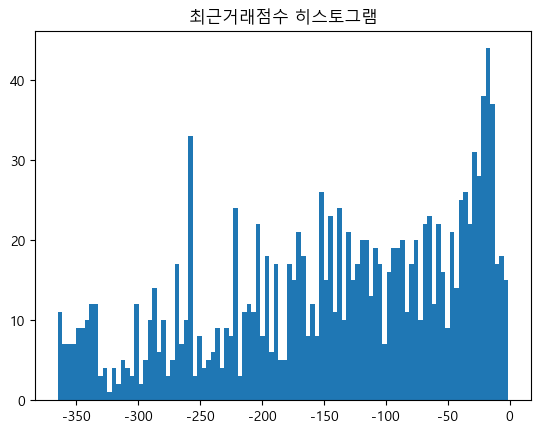

In [14]:
feature_date=pd.to_datetime('2019-12-31')-old_customer['최근거래날짜'] # 메모 12월 31 거래날짜 일치는 6개
feature_data1= -(feature_date.dt.days.values +1)

plt.hist(feature_data1, bins =100);
plt.title('최근거래점수 히스토그램')
plt.show()

`-` 거래빈도

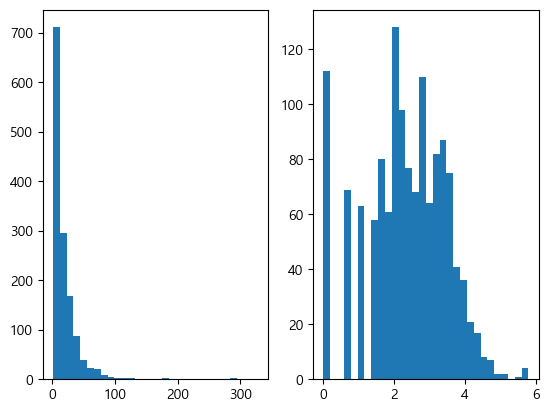

In [15]:
feature_data2=old_customer['거래빈도'].values


fig, ax = plt.subplots(1, 2)
ax[0].hist(feature_data2, bins =30);
#ax[0].set_title('최근거래날짜점수 히스토그램')

ax[1].hist(np.log(feature_data2), bins =30);
#ax[1].set_title('최근거래날짜점수 히스토그램')
plt.show()

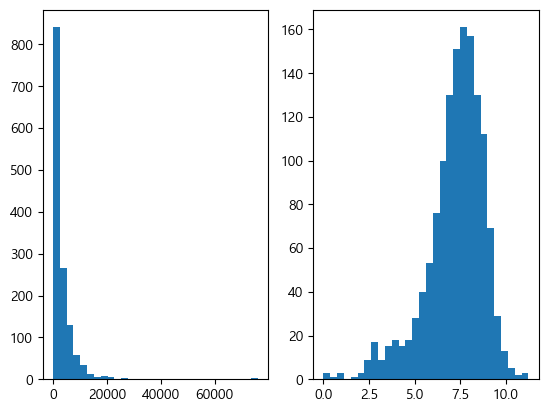

In [16]:
feature_data3=old_customer['거래총금액'].values
fig, ax = plt.subplots(1, 2)
ax[0].hist(feature_data3, bins =30);
#ax[0].set_title('최근거래날짜점수 히스토그램')

ax[1].hist(np.log(feature_data3), bins =30);
#ax[1].set_title('최근거래날짜점수 히스토그램')
plt.show()

In [17]:
cluster_df= pd.DataFrame({'x1':feature_data1,
             'x2':np.log(feature_data2),
             'x3':np.log(feature_data3)})

---


### `-` data 스케일링 
- minmax 방식 채택

In [18]:
from sklearn.preprocessing import *

minmax = MinMaxScaler()
standard = StandardScaler()
cluster_scale =standard.fit_transform(cluster_df)
cluster_scale2 =minmax.fit_transform(cluster_df)

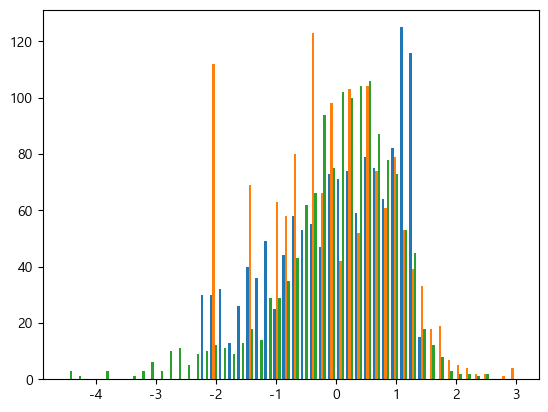

In [43]:
plt.hist(cluster_scale,bins=50);

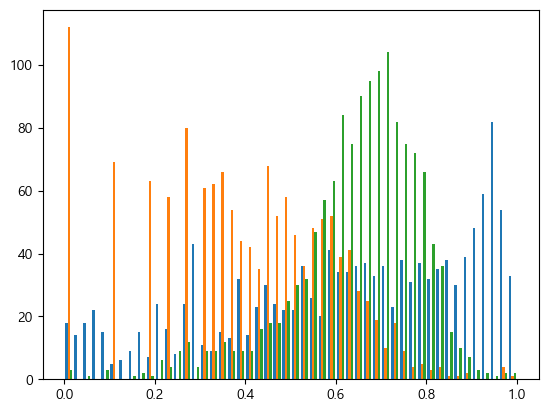

In [19]:
plt.hist(cluster_scale2,bins=50);

---

### 계층적 군집분석 model fitting

In [44]:
from sklearn.cluster import KMeans,AgglomerativeClustering

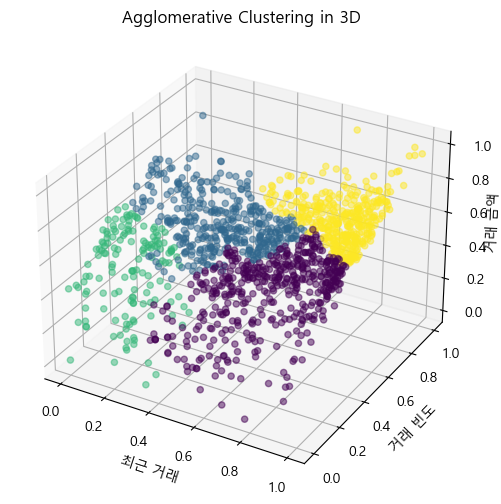

In [45]:
model = AgglomerativeClustering(n_clusters=4,linkage = "complete",
                               compute_full_tree =True,metric='euclidean')
clusters2 = model.fit_predict(cluster_scale2)

# 결과 시각화
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(cluster_scale2[:, 0], cluster_scale2[:, 1], cluster_scale2[:, 2], c=clusters2, cmap='viridis', s=20, alpha=0.5)
ax.set_title('Agglomerative Clustering in 3D')
ax.set_xlabel('최근 거래')
ax.set_ylabel('거래 빈도')
#ax.set_zlabel('거래 금액')
ax.set_zlabel('거래 금액', labelpad=0)
ax.tick_params(axis='z', pad=6)

plt.show()

In [23]:
ddf = pd.DataFrame(cluster_scale2)
ddf['y'] = clusters2
ddf.columns = ['최근성', '최빈성', '금액','y']
ddf.head()

,최근성,최빈성,금액,y
0,0.706044,0.000000,0.305550,0
1,0.837912,0.592781,0.848481,3
2,0.799451,0.358957,0.647276,0
3,0.953297,0.413929,0.642063,0
4,0.706044,0.442766,0.647297,0


---

# 계층적 군집분석 결과

- 0 : 잠재적충성
- 1 : 잠재적이탈
- 2 : 이탈
- 3 : 충성

In [24]:
ddf.groupby('y').mean()

,최근성,최빈성,금액
y,,,
0,0.740539,0.254323,0.550025
1,0.415265,0.458071,0.684958
2,0.170293,0.184581,0.497585
3,0.847785,0.605804,0.772847


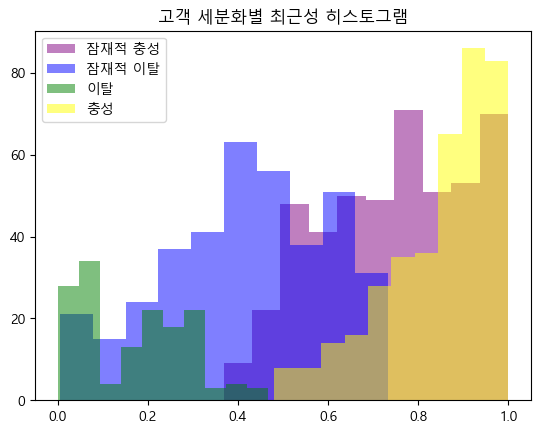

In [34]:
plt.hist('최근성',data=ddf[ddf['y']==0],label='잠재적 충성',alpha=0.5,color = 'purple')
plt.hist('최근성',data=ddf[ddf['y']==1],label='잠재적 이탈',alpha=0.5,color='blue')
plt.hist('최근성',data=ddf[ddf['y']==2],label='이탈',alpha=0.5,color='green')
plt.hist('최근성',data=ddf[ddf['y']==3],label='충성',alpha=0.5,color = 'yellow')
plt.legend()
plt.title("고객 세분화별 최근성 히스토그램")
plt.show()

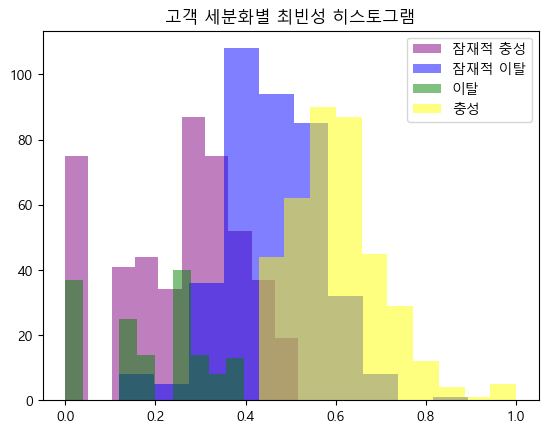

In [35]:
plt.hist('최빈성',data=ddf[ddf['y']==0],label='잠재적 충성',alpha=0.5,color = 'purple')
plt.hist('최빈성',data=ddf[ddf['y']==1],label='잠재적 이탈',alpha=0.5,color='blue')
plt.hist('최빈성',data=ddf[ddf['y']==2],label='이탈',alpha=0.5,color='green')
plt.hist('최빈성',data=ddf[ddf['y']==3],label='충성',alpha=0.5,color = 'yellow')
plt.legend()
plt.title("고객 세분화별 최빈성 히스토그램")
plt.show()

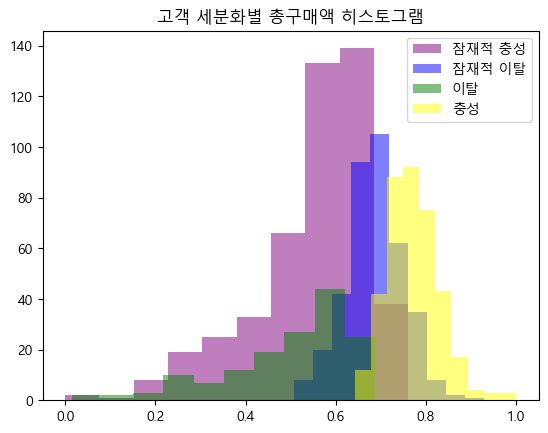

In [36]:
plt.hist('금액',data=ddf[ddf['y']==0],label='잠재적 충성',alpha=0.5,color = 'purple')
plt.hist('금액',data=ddf[ddf['y']==1],label='잠재적 이탈',alpha=0.5,color='blue')
plt.hist('금액',data=ddf[ddf['y']==2],label='이탈',alpha=0.5,color='green')
plt.hist('금액',data=ddf[ddf['y']==3],label='충성',alpha=0.5,color = 'yellow')
plt.legend()
plt.title("고객 세분화별 총구매액 히스토그램")
plt.show()

In [29]:
old_customer_= old_customer.reset_index()
old_customer_['고객등급'] = ddf['y']

potential_in = old_customer_[old_customer_['고객등급'] == 0]['index']
potential_out = old_customer_[old_customer_['고객등급'] == 1]['index']
certainty_out = old_customer_[old_customer_['고객등급'] == 2]['index']
certainty_in = old_customer_[old_customer_['고객등급'] == 3]['index'].values

In [48]:
user_num = np.array([int(df['고객ID'][i][5:]) for i in range(len(df))])
df['user_num'] =user_num # 유저넘버 변수 추가 등급을 찾기 위해서

In [49]:
certainty_in_df = pd.DataFrame({'user_num':certainty_in})
certainty_out_df = pd.DataFrame({'user_num':certainty_out})
potential_in_df = pd.DataFrame({'user_num':potential_in})
potential_out_df = pd.DataFrame({'user_num':potential_out})

In [50]:
# 고객 등급별 특성 추출
certainty_in_customer = pd.merge(df, certainty_in_df,how='inner',on = 'user_num')
certainty_out_customer = pd.merge(df, certainty_out_df,how='inner',on = 'user_num')
potential_in_customer = pd.merge(df, potential_in_df,how='inner',on = 'user_num')
potential_out_customer = pd.merge(df, potential_out_df,how='inner',on = 'user_num')

### 이탈 고객 특징

- 이산형변수

In [51]:
certainty_out_customer.head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액,user_num
0,USER_0345,여,California,30,Transaction_0013,2019-01-01,Product_0971,Lifestyle,1,1.24,6.5,Clicked,1.24,345
1,USER_1347,여,New Jersey,24,Transaction_0050,2019-01-02,Product_0951,Office,1,3.08,6.5,Clicked,3.08,1347
2,USER_1347,여,New Jersey,24,Transaction_2302,2019-02-04,Product_0976,Nest-USA,1,119.00,6.5,Used,119.00,1347
3,USER_1347,여,New Jersey,24,Transaction_2312,2019-02-04,Product_0177,Bottles,20,2.99,6.5,Clicked,59.80,1347
4,USER_1347,여,New Jersey,24,Transaction_2312,2019-02-04,Product_0285,Apparel,1,16.99,6.5,Clicked,16.99,1347


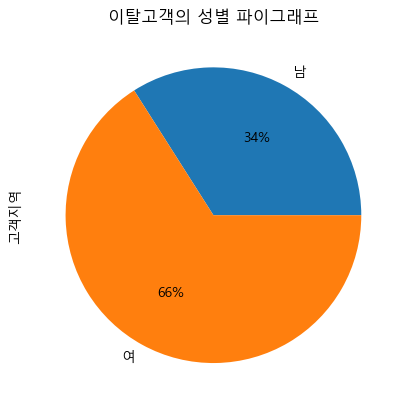

In [52]:
certainty_out_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('이탈고객의 성별 파이그래프')
plt.show()

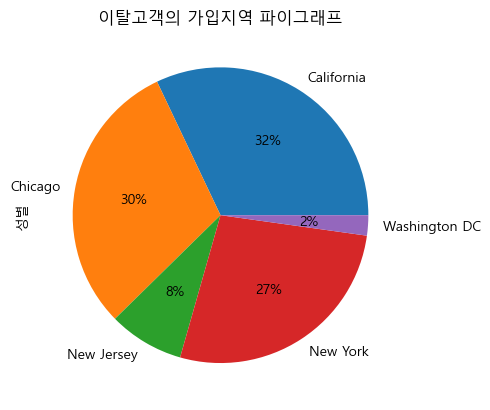

In [53]:
certainty_out_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('이탈고객의 가입지역 파이그래프')
plt.show()

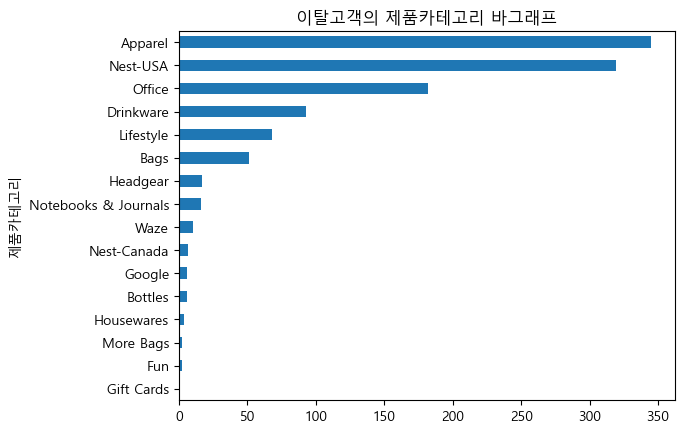

In [54]:
certainty_out_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('이탈고객의 제품카테고리 바그래프')
plt.show()

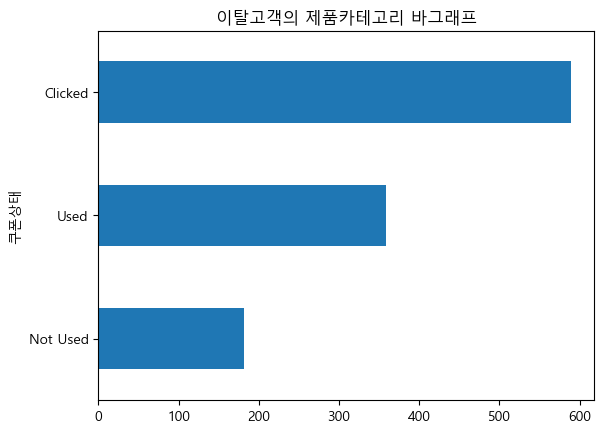

In [55]:
certainty_out_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('이탈고객의 제품카테고리 바그래프')
plt.show()

`-` 연속형 변수

In [56]:
certainty_out_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,30.192205,4.050487,48.139203,10.601346,75.695031
std,12.385121,12.149633,54.694996,16.063460,93.873973
min,9.000000,1.000000,0.790000,0.000000,0.990000
25%,19.000000,1.000000,4.990000,6.500000,13.590000
50%,32.000000,1.000000,18.990000,6.500000,32.960000
75%,41.000000,2.000000,104.000000,6.500000,122.770000
max,50.000000,155.000000,256.880000,323.470000,768.550000


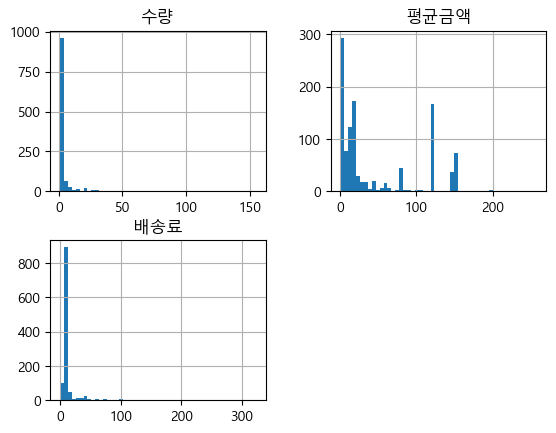

In [57]:
certainty_out_customer[['수량','평균금액','배송료']].hist(bins=50);

---

### 잠재적 이탈 고객 특징
- 이산형변수

In [58]:
potential_out_customer.head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액,user_num
0,USER_1358,남,Chicago,12,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1358
1,USER_1358,남,Chicago,12,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1358
2,USER_1358,남,Chicago,12,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,2.05,1358
3,USER_1358,남,Chicago,12,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,87.65,1358
4,USER_1358,남,Chicago,12,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,16.50,1358


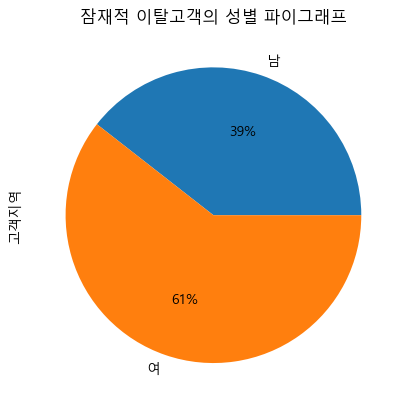

In [59]:
potential_out_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 이탈고객의 성별 파이그래프')
plt.show()

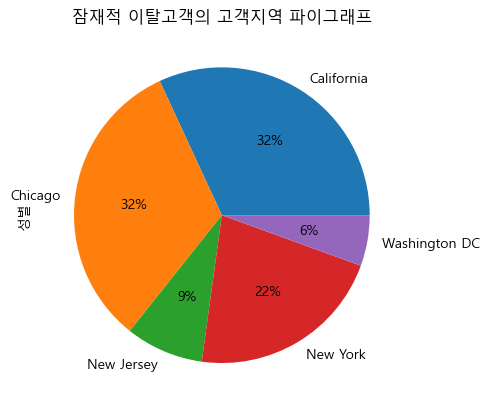

In [60]:
potential_out_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 이탈고객의 고객지역 파이그래프')
plt.show()

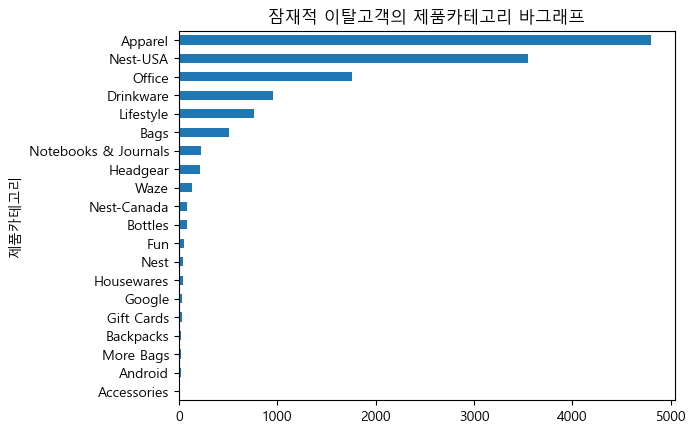

In [61]:
potential_out_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 이탈고객의 제품카테고리 바그래프')
plt.show()

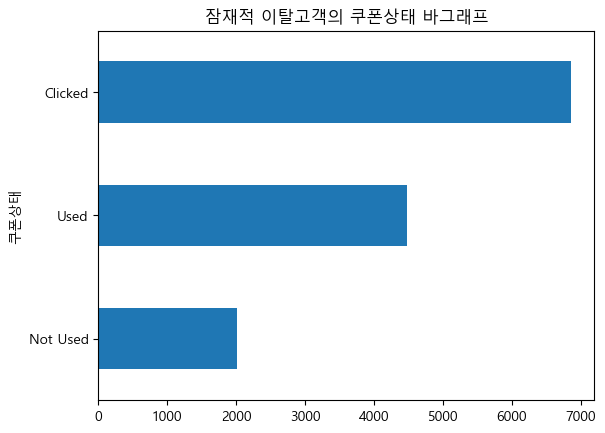

In [62]:
potential_out_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 이탈고객의 쿠폰상태 바그래프')
plt.show()

`-` 연속형변수

In [63]:
potential_out_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,13349.000000,13349.000000,13349.000000,13349.000000,13349.000000
mean,28.500037,4.966365,46.122417,11.255868,81.533906
std,12.080557,20.005820,53.713896,20.411760,132.278413
min,5.000000,1.000000,0.790000,0.000000,0.790000
25%,18.000000,1.000000,6.000000,6.000000,12.790000
50%,29.000000,1.000000,16.500000,6.500000,29.900000
75%,39.000000,2.000000,81.500000,6.500000,119.000000
max,50.000000,600.000000,349.000000,422.240000,5316.000000


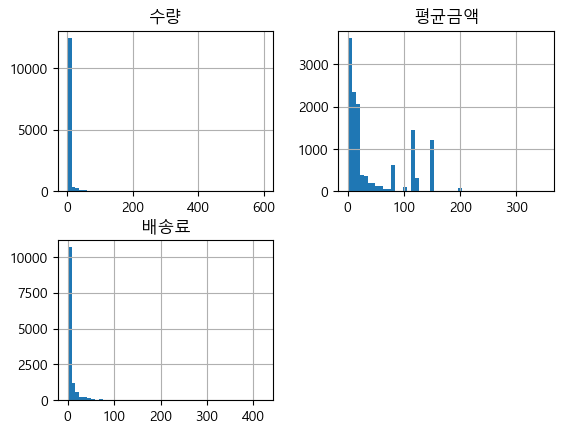

In [64]:
potential_out_customer[['수량','평균금액','배송료']].hist(bins=50);

---

### 잠재적 충성 고객 특성
- 이산형변수

In [65]:
potential_in_customer.head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액,user_num
0,USER_0683,남,California,49,Transaction_0023,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Clicked,153.71,683
1,USER_0683,남,California,49,Transaction_5384,2019-03-26,Product_0983,Nest-USA,1,119.00,6.50,Clicked,119.00,683
2,USER_0683,남,California,49,Transaction_5689,2019-03-30,Product_0880,Drinkware,5,2.39,12.48,Clicked,11.95,683
3,USER_0683,남,California,49,Transaction_10783,2019-06-19,Product_0981,Nest-USA,5,149.00,12.91,Used,745.00,683
4,USER_0683,남,California,49,Transaction_14636,2019-08-14,Product_0447,Apparel,1,4.08,6.00,Used,4.08,683


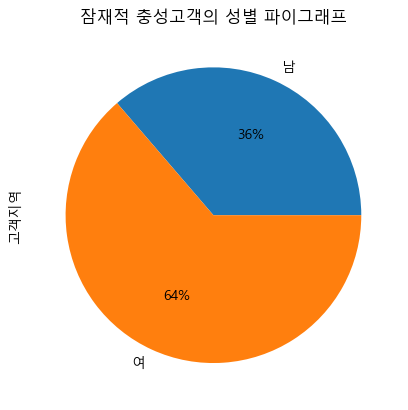

In [66]:
potential_in_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 성별 파이그래프')
plt.show()

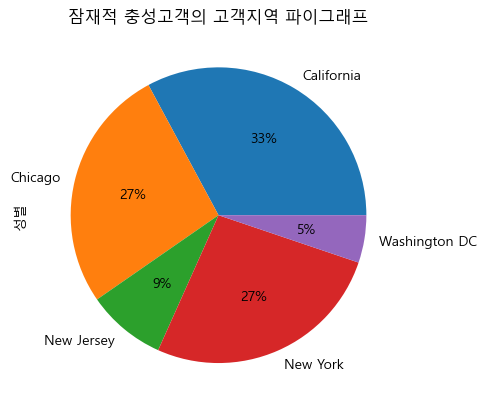

In [67]:
potential_in_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 고객지역 파이그래프')
plt.show()

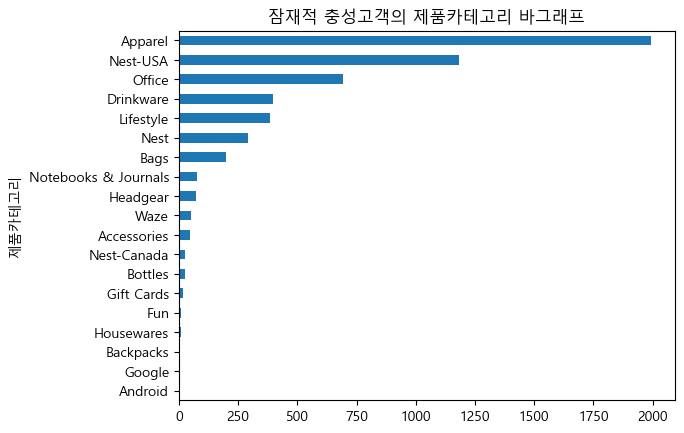

In [68]:
potential_in_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 제품카테고리 바그래프')
plt.show()

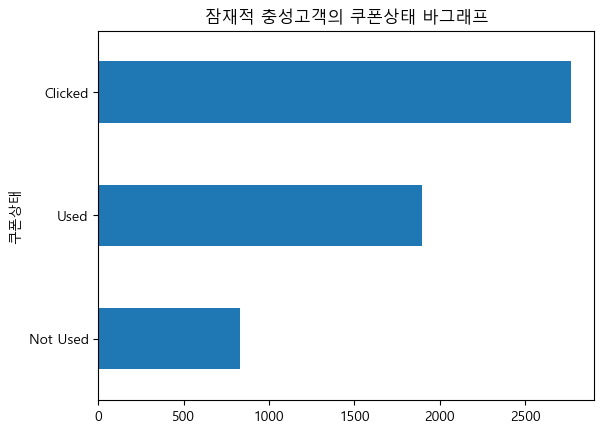

In [69]:
potential_in_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 쿠폰상태 바그래프')
plt.show()

`-` 연속형변수

In [70]:
potential_in_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,26.797996,3.910747,47.322536,10.523754,76.268007
std,13.390032,15.491041,65.641910,26.327441,114.731292
min,3.000000,1.000000,0.400000,0.000000,0.400000
25%,15.000000,1.000000,4.560000,6.000000,9.490000
50%,27.000000,1.000000,13.990000,6.000000,21.990000
75%,38.000000,2.000000,79.000000,6.500000,119.000000
max,50.000000,600.000000,355.740000,504.000000,1495.000000


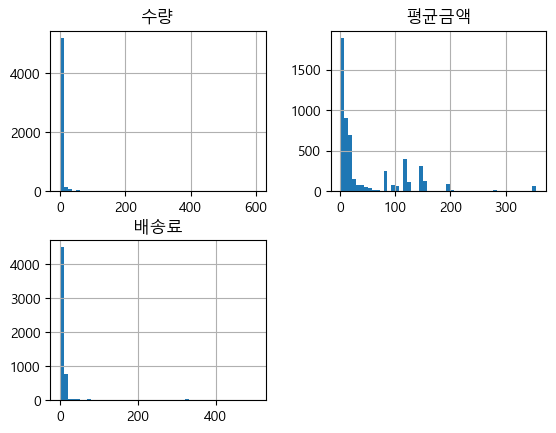

In [71]:
potential_in_customer[['수량','평균금액','배송료']].hist(bins=50);

---

### 충성 고객 특징
- 이산형 변수

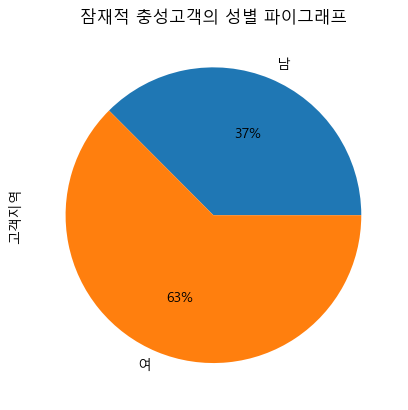

In [72]:
certainty_in_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 성별 파이그래프')
plt.show()

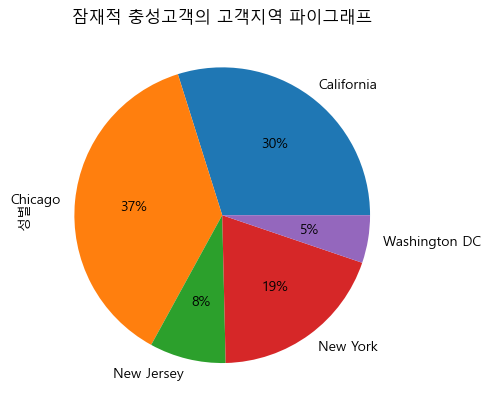

In [73]:
certainty_in_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 고객지역 파이그래프')
plt.show()

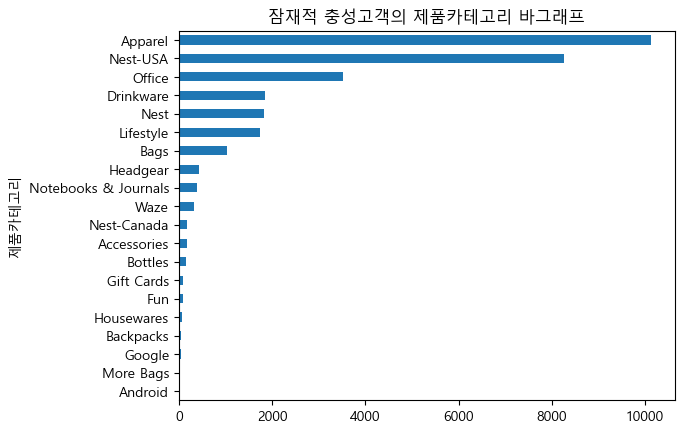

In [74]:
certainty_in_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 제품카테고리 바그래프')
plt.show()

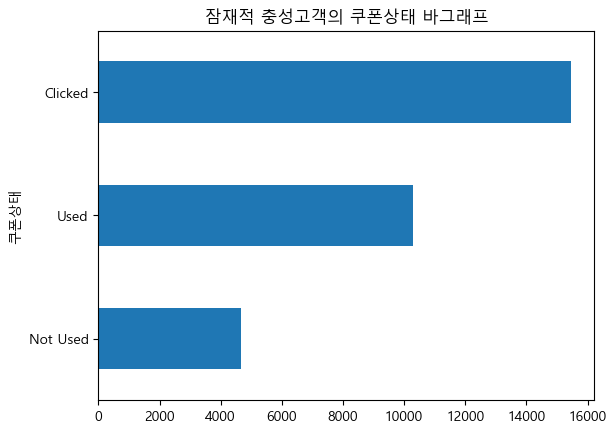

In [75]:
certainty_in_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 쿠폰상태 바그래프')
plt.show()

`-` 연속형변수

In [76]:
certainty_in_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,30406.000000,30406.000000,30406.000000,30406.000000,30406.000000
mean,26.637933,4.430902,56.251541,10.080808,94.395703
std,13.064578,21.503124,68.282826,17.702704,187.951373
min,2.000000,1.000000,0.390000,0.000000,0.400000
25%,16.000000,1.000000,5.990000,6.000000,11.980000
50%,27.000000,1.000000,17.590000,6.000000,33.590000
75%,37.000000,2.000000,119.000000,6.500000,131.850000
max,50.000000,900.000000,355.740000,521.360000,10512.390000


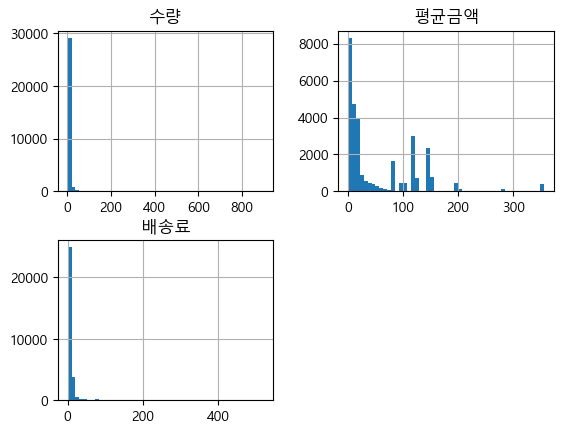

In [77]:
certainty_in_customer[['수량','평균금액','배송료']].hist(bins=50);

---

# 고객 분류 알고리즘
- 비지도학습을 통해 고객 세분화 등급을 딥러닝 모형에 적합
    - feature : 고객의 RFM
    - y_label : 고객 세분화 등급
- 모델설명
    - fully connected layer로 구성, 7개의 히든레이어층
    - 뉴련 512개로 시작하며 절반씩 감소하여 구성
    - 히든레이어마다 드랍아웃 0.2 적용
    - 배치사이즈 4, 학습방식은 adam, 학습률 0.000015
    - softmax, y 확률 반환
    - 입력층 차원 sequence =3, feature=3
    

In [78]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense ,Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.optimizers import Adam

### train/test set, 원핫인코딩

In [79]:
X = ddf.iloc[:,:3]
y= ddf.iloc[:,3]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y)

y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)


---

### 딥러닝 모델

In [109]:
K.clear_session()
model0 = Sequential() # Sequeatial Model
model0.add(Dense(512, input_shape=(3, 3),activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(256,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(128,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(64,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(32,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(16,activation='relu'))
#model0.add(Dense(64,activation='linear'))
model0.add(Dense(4, activation='softmax')) # output = 1
adam_optimizer = Adam(learning_rate=0.000015)

model0.compile(loss='categorical_crossentropy', optimizer=adam_optimizer ,metrics=['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model0.save('my_model.keras')
history= model0.fit(X_train, y_train_one_hot, epochs=200,
          batch_size=4, verbose=1, callbacks=[early_stop, checkpoint],validation_data=(X_test, y_test_one_hot))


Epoch 1/200
229/257 [=========================>....] - ETA: 0s - loss: 1.3945 - accuracy: 0.1517
Epoch 1: val_accuracy improved from -inf to 0.45190, saving model to best_model.h5
257/257 [==============================] - 1s 2ms/step - loss: 1.3939 - accuracy: 0.1537 - val_loss: 1.3846 - val_accuracy: 0.4519
Epoch 2/200
 91/257 [=========>....................] - ETA: 0s - loss: 1.3889 - accuracy: 0.2363

C:\Users\minu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/257 [============================>.] - ETA: 0s - loss: 1.3873 - accuracy: 0.2343
Epoch 2: val_accuracy did not improve from 0.45190
257/257 [==============================] - 0s 2ms/step - loss: 1.3873 - accuracy: 0.2335 - val_loss: 1.3825 - val_accuracy: 0.3761
Epoch 3/200
256/257 [============================>.] - ETA: 0s - loss: 1.3843 - accuracy: 0.2871
Epoch 3: val_accuracy did not improve from 0.45190
257/257 [==============================] - 0s 2ms/step - loss: 1.3842 - accuracy: 0.2879 - val_loss: 1.3791 - val_accuracy: 0.2857
Epoch 4/200
227/257 [=========================>....] - ETA: 0s - loss: 1.3797 - accuracy: 0.3502
Epoch 4: val_accuracy did not improve from 0.45190
257/257 [==============================] - 0s 2ms/step - loss: 1.3797 - accuracy: 0.3405 - val_loss: 1.3734 - val_accuracy: 0.3236
Epoch 5/200
233/257 [==========================>...] - ETA: 0s - loss: 1.3744 - accuracy: 0.3766
Epoch 5: val_accuracy did not improve from 0.45190
257/257 [==================

---

### baseline

- minmax 변환를 제외한 로그 변환은 하지 않음  
- 분포를 고려하지 않았을 때 예측력에 차이가 얼마나 있는지 보기위함
- 모델 세팅 및 학습 횟수는 동일하게 진행

In [131]:
base_X= pd.DataFrame({'x1':feature_data1,
             'x2':feature_data2,
             'x3':feature_data3})
base_X =minmax.fit_transform(base_X)
X_train_b,X_test_b,y_train_b,y_test_b= train_test_split(base_X,y)


y_train_one_hot_b = to_categorical(y_train_b, num_classes=4)
y_test_one_hot_b = to_categorical(y_test_b, num_classes=4)


In [133]:
K.clear_session()
model_base = Sequential() # Sequeatial Model
model_base.add(Dense(512, input_shape=(3, 3),activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(256,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(128,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(64,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(32,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(16,activation='relu'))
#model0.add(Dense(64,activation='linear'))
model_base.add(Dense(4, activation='softmax')) # output = 1
adam_optimizer = Adam(learning_rate=0.000015)

model_base.compile(loss='categorical_crossentropy', optimizer=adam_optimizer ,metrics=['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=100, verbose=0, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
#model_base.save('my_model.keras')
history_base= model_base.fit(X_train_b, y_train_one_hot_b, epochs=1000,
          batch_size=4, verbose=0, callbacks=[early_stop, checkpoint],validation_data=(X_test, y_test_one_hot))

C:\Users\minu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

### model0 추가 epoch

In [110]:
early_stop = EarlyStopping(monitor='loss', patience=100, verbose=0, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
model0.save('my_model.keras')
history2= model0.fit(X_train, y_train_one_hot, epochs=800,
          batch_size=4, verbose=0, callbacks=[early_stop, checkpoint],validation_data=(X_test, y_test_one_hot))


C:\Users\minu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 모델0 loss 그래프

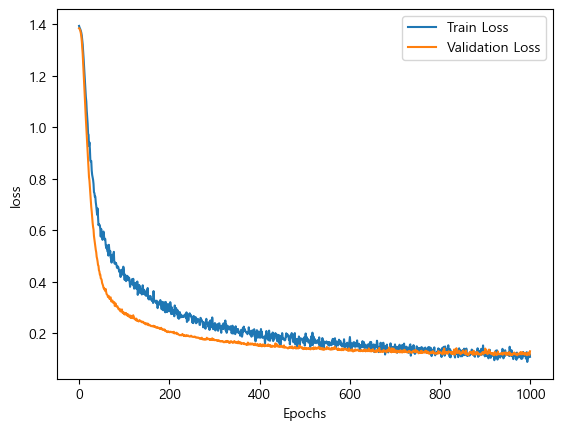

In [121]:
# loss 그래프 
plt.plot(history.history['loss'] + history2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss']+history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

---


### base 모델 loss 그래프

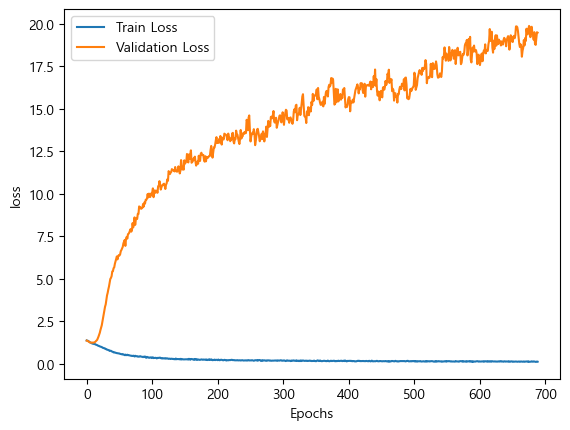

In [142]:
# baseline loss 그래프 
plt.plot(history_base.history['loss'] ,label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

---

### 모델0 accuracy 그래프

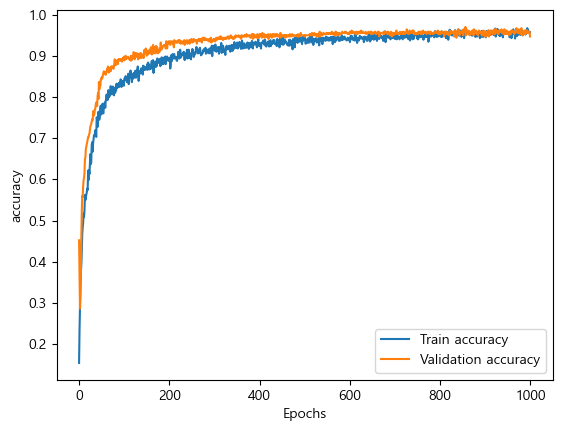

In [123]:
# accuracy 그래프 
plt.plot(history.history['accuracy']+history2.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy']+history2.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

---

### base 모델 accuracy 그래프

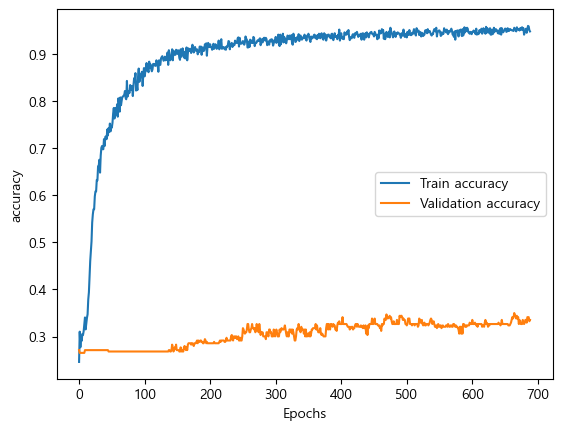

In [143]:
# baseline accuracy 그래프 
plt.plot(history_base.history['accuracy'], label='Train accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [113]:
from keras.models import load_model

# 가장 높은 성능을 보인 모델 불러오기
best_model = load_model('best_model.h5')


In [144]:
pred = model0.predict(X_test)
pred1= best_model.predict(X_test)
pred2 = model_base.predict(X_test_b)

11/11 [==============================] - 0s 988us/step


In [145]:
from sklearn.metrics import accuracy_score

pred_ =np.argmax(pred, axis=1)
pred1_ =np.argmax(pred1, axis=1)
pred2_ =np.argmax(pred2, axis=1)

accuracy = accuracy_score(y_test,pred_)
accuracy1 = accuracy_score(y_test,pred1_)
accuracy2 = accuracy_score(y_test_b,pred2_)
print('basemodel accuracy score : ',accuracy2.round(3))
print('bestmodel accuracy score : ',accuracy1.round(3))

basemodel accuracy score :  0.962
bestmodel accuracy score :  0.971


- 군집분석으로 고객을 세분화후 딥러닝을 통해 고객의 RFM을 학습함
- 딥러닝 모델의 정확성은 98.8%, 학습데이터의 분포가 고객 분류에 있어 상당희 유의하게 잘 만들어진 것을 알 수 있다.